This notebooks plots some descriptive statistics of the raw text data.


## Inputs

- `data/pubmed/abstracts_2023.csv.gz`: raw text data

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.cogtext.datasets.pubmed import PubMedDataset
from wordcloud import WordCloud

import polars as pl

sns.set('notebook')

In [2]:
data = PubMedDataset(year=2023).load()
data = PubMedDataset.select_relevant_journals(data)
data = PubMedDataset.remove_short_abstracts(data, min_words=10)

In [3]:
n_articles = len(data)
n_unique_articles = data.unique('pmid').shape[0]
abstract_words_median = data['abstract'].str.split(' ').map_elements(lambda x: len(x)).median()
print(f'Dataset contains {n_articles} relevant articles, of which {n_unique_articles} are unique.')
print(f'Median number of words per abstract: {abstract_words_median:.0f}.')

Dataset contains 413438 relevant articles, of which 283383 are unique.
Median number of words per abstract: 228.


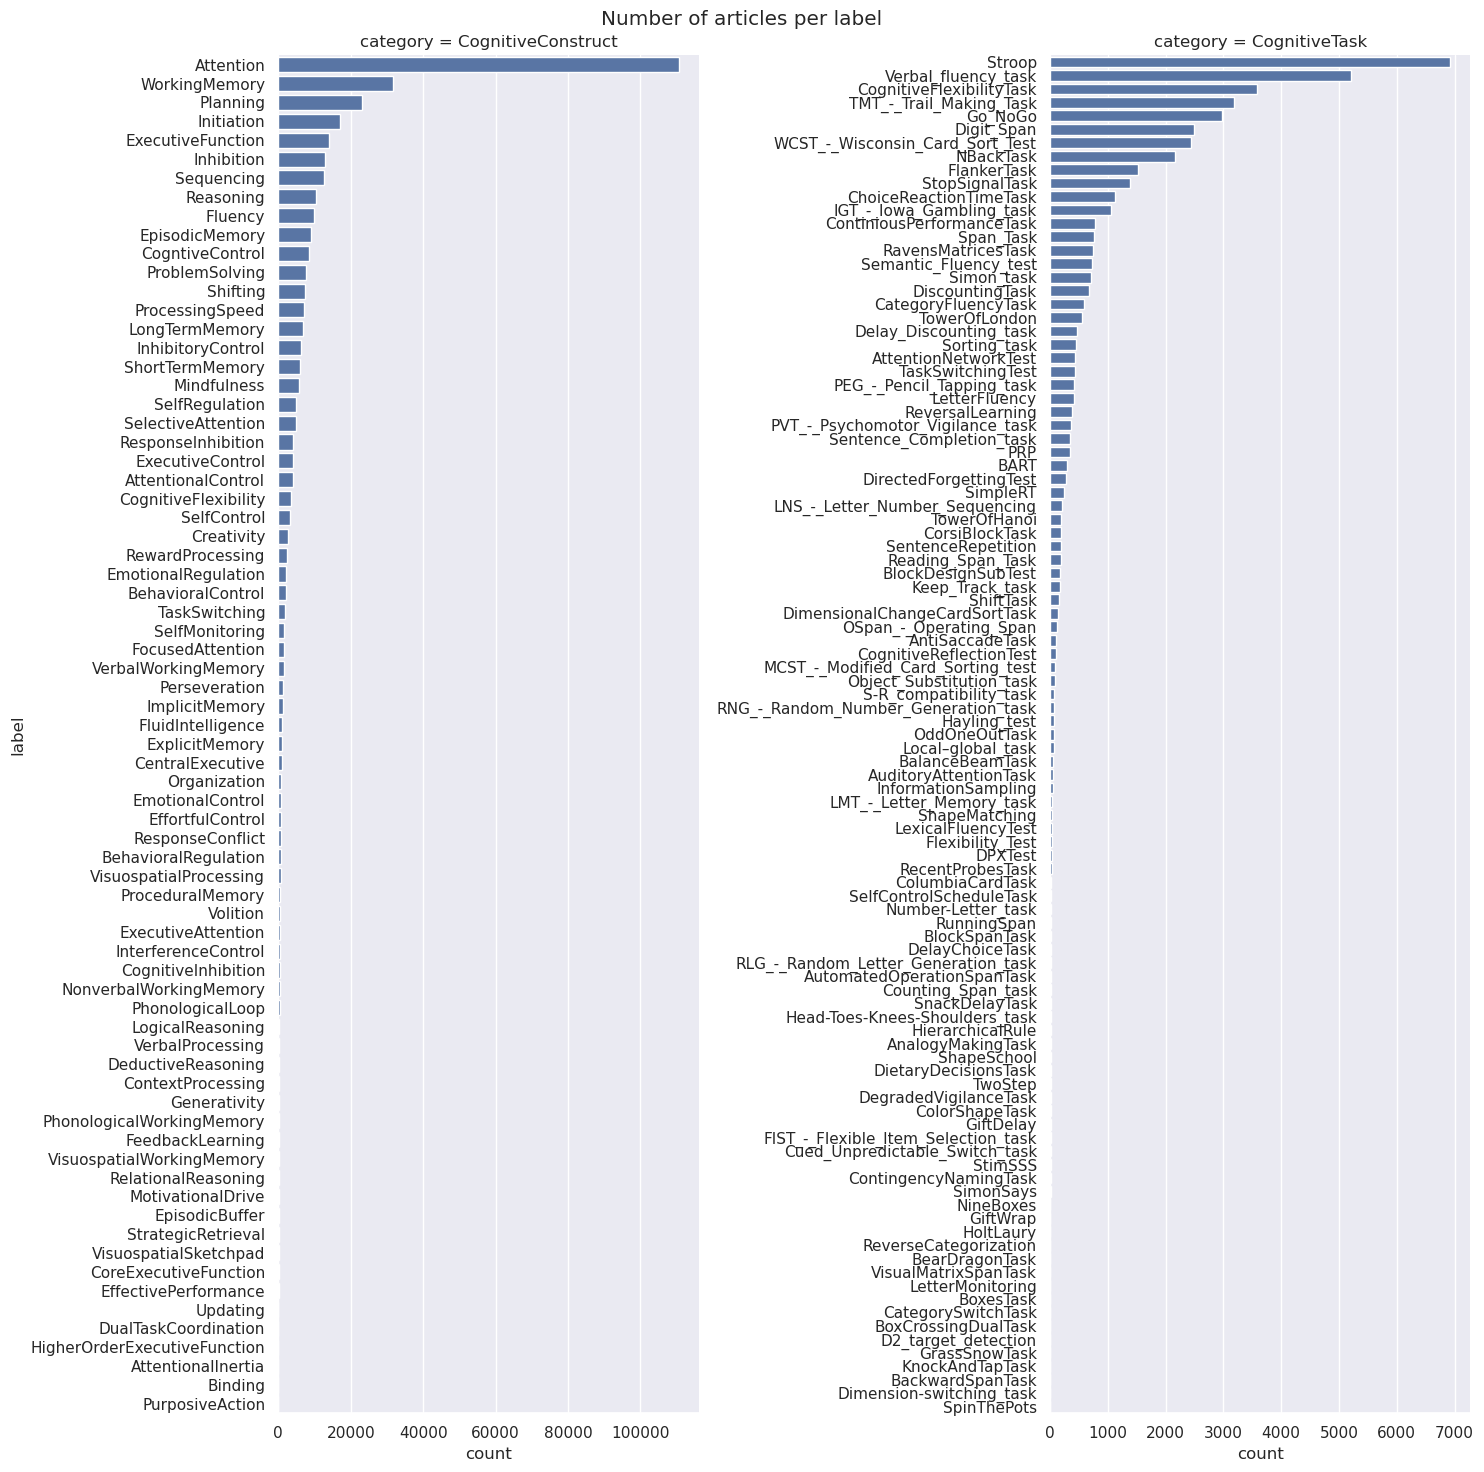

In [10]:
# plot number of articles for each lexicon term (or labels).

plot_data = (data.group_by(['category', 'label'])
                 .n_unique()
                 .sort(by='pmid', descending=True)[['category','label','pmid']]
                 .rename({'pmid': 'count'})
                 .to_pandas())

sns.catplot(data=plot_data, x='count', y='label', col='category',
            orient='h', kind='bar', height=15, aspect=0.5,
            sharex=False, sharey=False)

plt.suptitle('Number of articles per label')
plt.tight_layout()
plt.show()

### **:warning: the rest of the notebook requires to be rewritten using polars :warning:**

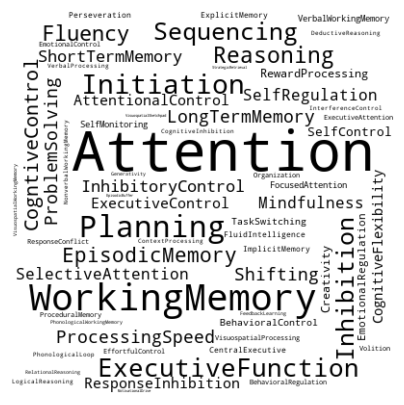

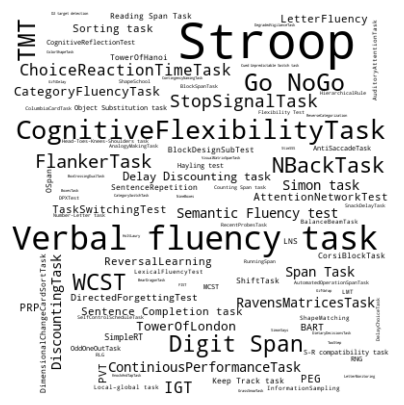

In [16]:
# wordclouds

def get_freq_dict(data, category):

    _freq_df = data.groupby(['category','label'])[['pmid']].nunique().reset_index()

    _freq_df = _freq_df.query('category == @category')[['label','pmid']]
    _freq_df['label'] = _freq_df['label'].apply(lambda x: x.replace('_',' '))
    _freq_df['label'] = _freq_df['label'].apply(lambda x: x.split(' - ', 1)[0])
    _freq_df.set_index('label', inplace=True)
    _freq_dict = _freq_df['pmid'].to_dict()
    return _freq_dict

# constructs
wc = WordCloud(background_color="white", max_words=200, width=400, height=400,
               color_func=lambda *args, **kwargs: 'black')
wc.generate_from_frequencies(get_freq_dict(data, 'CognitiveConstruct'))
plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('cognitive_constructs.png', dpi=300, bbox_inches='tight')


# tasks
wc = WordCloud(background_color="white", max_words=200, width=400, height=400,
               color_func=lambda *args, **kwargs: 'black')
wc.generate_from_frequencies(get_freq_dict(data, 'CognitiveTask'))
plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('cognitive_tasks.png', dpi=300, bbox_inches='tight')


In [17]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(counts)

min_year, max_year = data.query('label == "Stroop"')['year'].apply([min, max])
print(f'Stroop articles span from {min_year} to {max_year}.')

Stroop articles span from 1973 to 2023.


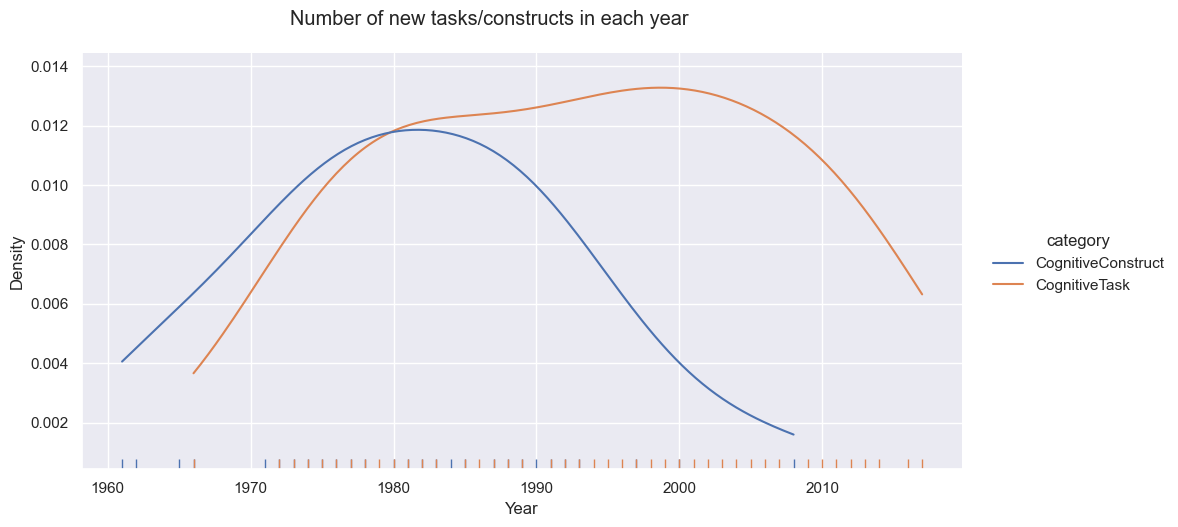

In [18]:
# plot first appearance of task/construct as a function of time

appearances = data.groupby(['category','label'])['year'].min().reset_index()

import seaborn as sns

appearances = appearances.groupby(['year','category']).nunique().reset_index()

# 2021 corpus is incomplete, so we drop it
appearances = appearances.query('year <= 2020')

# sns.kdeplot(x='year', data=appearances, hue='category', ax=ax, cut=0)
sns.displot(
  x='year',
  data=appearances,
  hue='category',
  kind='kde', cut=0, rug=True,
  height=5, aspect=2)

plt.suptitle('Number of new tasks/constructs in each year', y=1.05, x=.42)
plt.xlabel('Year')
# ax.legend_.set_title(None)
plt.show()

In [20]:
# report first and last years of the "first appearances'

appearances.groupby(['category']).agg({'year': ['min','max']}).rename(columns={'year': 'first_appearance'})

first_appearance      
                                min   max
category                                 
CognitiveConstruct             1961  2008
CognitiveTask                  1966  2017